In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.stats as astats
from astropy import units as u
from mpl_toolkits.axes_grid1 import AxesGrid
import sys
from matplotlib.path import Path
from scipy import interpolate
from scipy.optimize import fsolve
import emcee
import corner
from colorspacious import cspace_convert
import cmath

In [2]:
# Opens a text file and stores the data in field_data.
def read_txt (name, cols = None):
    field_data = np.loadtxt(name, comments='#', usecols = cols)
    return field_data.T

In [45]:
# Get the data
name_file = '/home/pol/Documents/PhD/CMD_SMASH/SB_data_errors_mesa_decam_msto_9O.dat'
all_data = read_txt(name_file)
fields_coords = np.stack((all_data[1],all_data[2]))
#data_dict = {all_data[0]:(all_data[1], all_data[3])}

In [46]:
print all_data.T

[[1.000000e+00 4.543000e+00 3.066610e+02 3.076045e+01 4.342000e-02]
 [2.000000e+00 4.775000e+00 2.032150e+02 3.073781e+01 4.119000e-02]
 [3.000000e+00 2.388000e+00 2.380140e+02 2.666424e+01 3.963000e-02]
 [4.000000e+00 2.122000e+00 2.787050e+02 2.752944e+01 4.067000e-02]
 [5.000000e+00 1.367000e+00 3.302200e+02 2.635114e+01 3.977000e-02]
 [6.000000e+00 7.180000e-01 2.354230e+02 2.591414e+01 4.066000e-02]
 [7.000000e+00 2.047000e+00 1.942320e+02 2.640662e+01 3.977000e-02]
 [8.000000e+00 9.646000e+00 1.804220e+02 3.368111e+01 2.556600e-01]
 [9.000000e+00 2.217000e+00 1.895300e+01 2.726070e+01 3.934000e-02]
 [1.000000e+01 9.620000e-01 5.907200e+01 2.591907e+01 4.208000e-02]
 [1.100000e+01 1.433000e+00 1.395430e+02 2.628836e+01 3.977000e-02]
 [1.200000e+01 2.851000e+00 1.587660e+02 2.772914e+01 3.864000e-02]
 [1.300000e+01 5.879000e+00 1.678580e+02 3.084899e+01 3.968000e-02]
 [1.400000e+01 2.648000e+00 5.702600e+01 2.725501e+01 3.934000e-02]
 [1.500000e+01 2.348000e+00 9.372000e+01 2.71387

In [4]:
def elliptical_radius(r, theta, pa, e):
    # Function that gives the elliptical correction to a circular radius.
    # r in arbitrary units
    # theta in degrees
    # position angle of the ellipse (pa) in degrees
    # eccentricity (e) of the ellipse
    x = r * np.cos(np.deg2rad(theta-pa))
    y = r * np.sin(np.deg2rad(theta-pa))
    #first_term = (x * np.cos(np.deg2rad(pa)) - y * np.sin(np.deg2rad(pa))) / (1.0 - e)
    #second_term = x * np.sin(np.deg2rad(pa)) + y * np.cos(np.deg2rad(pa))
    first_term = x
    second_term = y/(1-e)
    return np.sqrt(first_term**2 + second_term**2)

In [5]:
def lnlike(theta, x, pa, y, yerr):
    I_c, h, n, I_b, e, line_of_nodes = theta
    pa_radians = np.deg2rad(pa)
    #r_prime = np.sqrt(x*x * (np.cos(pa - line_of_nodes)**2 + np.sin(pa - line_of_nodes)**2 / (1.0-e*e)))
    r_prime = elliptical_radius(x, pa, line_of_nodes, e)
    model = - 2.5 * np.log10(I_c * np.exp(-1.0 * (r_prime/h)**(1.0/n)) + I_b)
    return -np.sum((y-model)**2 / (yerr)**2)

In [21]:
def lnprior(theta):
    I_c, h, n, I_b, e, line_of_nodes = theta
    if 1e-11 < I_c < 1e-8 and 0.0 < h < 20.0 and 0.0 < n < 10.0 and 1e-14 < I_b < 1e-11 and 0.0 < e < 1.0 and 0.0 <= line_of_nodes < 360:
        return 0.0
    return -np.inf

In [7]:
def lnprob(theta, x, pa, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, pa, y, yerr)

In [47]:
ndim, nwalkers = 6, 100
init_pos = [[1e-9, 1.0, 0.5, 1e-12, 0.1, 3.0] + 1e-14*np.random.randn(ndim) for i in range(nwalkers)]

In [48]:
#distance_SMC = 62 #kpc
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(all_data[1], all_data[2], all_data[3], all_data[4]))
number_iterations = 5000
sampler.run_mcmc(init_pos, number_iterations)

(array([[7.50203540e-11, 1.56572421e+00, 7.71193912e-01, 1.44671035e-13,
         5.53035082e-02, 5.07248337e+01],
        [7.21062716e-11, 1.63080312e+00, 7.42819776e-01, 1.63231974e-13,
         5.63754996e-02, 5.82474313e+01],
        [7.17117582e-11, 1.63811760e+00, 7.39936357e-01, 1.66499278e-13,
         5.57255052e-02, 5.73036042e+01],
        [7.02067764e-11, 1.63665739e+00, 7.44289161e-01, 1.55175514e-13,
         5.05521381e-02, 5.82931360e+01],
        [7.11428441e-11, 1.65191311e+00, 7.38137607e-01, 1.68968073e-13,
         6.37451566e-02, 5.56876702e+01],
        [7.13603746e-11, 1.62726072e+00, 7.47031564e-01, 1.56185187e-13,
         4.98207404e-02, 5.53275464e+01],
        [6.87541305e-11, 1.67143496e+00, 7.32302153e-01, 1.70862733e-13,
         5.28203093e-02, 5.42551366e+01],
        [7.54332633e-11, 1.55337042e+00, 7.73762945e-01, 1.43369618e-13,
         4.75316745e-02, 5.62403500e+01],
        [7.32917451e-11, 1.61353452e+00, 7.52520763e-01, 1.62439790e-13,
       

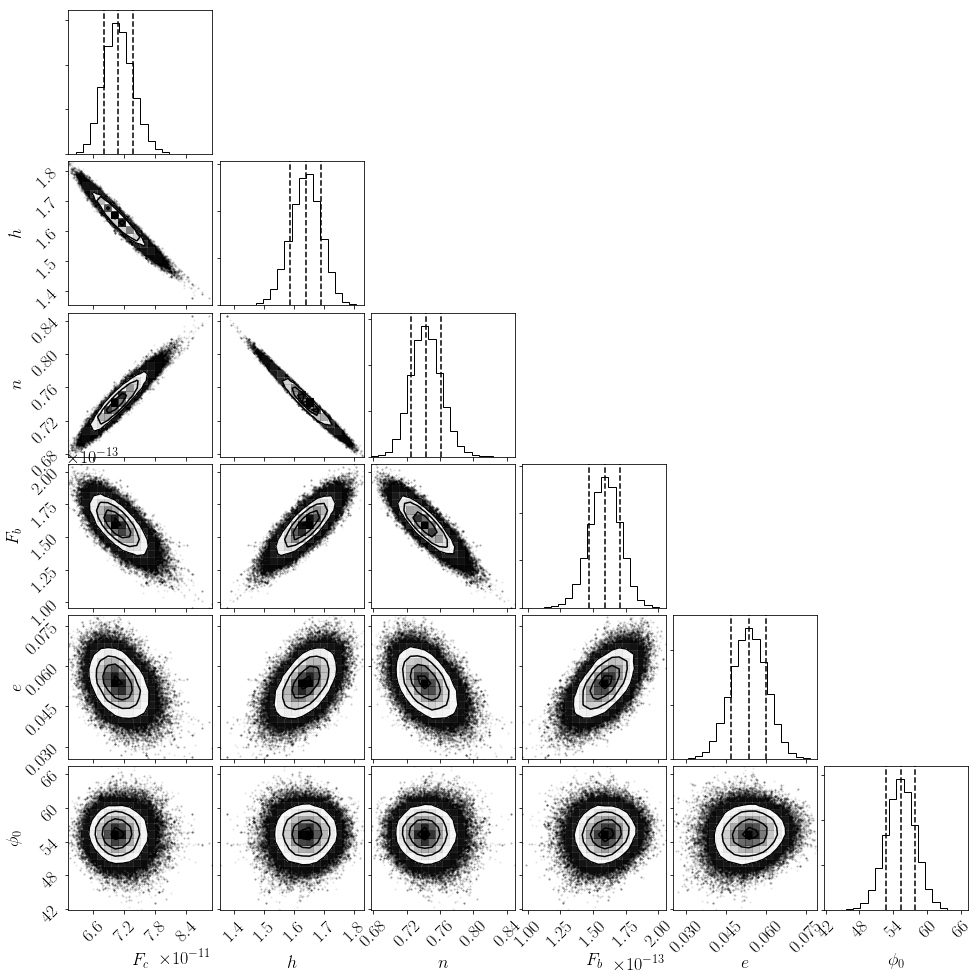

In [49]:
samples = sampler.chain[:, 2000:, :].reshape((-1, ndim))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':18})
fig = corner.corner(samples, labels=["$F_c$", "$h$", "$n$", "$F_b$", "$e$", "$\phi_0$"], quantiles = [0.16, 0.50, 0.84])
fig.savefig("/home/pol/Documents/PhD/CMD_SMASH/Plots/SB_sersic_9O.pdf")

In [11]:
def sersic_profile(x, params):
    I_c, h, n, I_b, e, line_of_nodes = params
    #r = x + a * np.cos(np.deg2rad(pa) + line_of_nodes)
    return -2.5 * np.log10(I_c * np.exp(-1.0 * (x/h)**(1.0/n)) + I_b)

In [43]:
def SB_profile_fit(fields_data, fields_errors, fields_radius, fields_pa, fields_number, params):
    I_c, h, n, I_b, e, line_of_nodes = params

    x_values = np.arange(0, 16.5, 0.1)
    y_values = sersic_profile(x_values, params)
    
    r_prime = elliptical_radius(fields_radius, fields_pa, line_of_nodes, e)
    
    residual_values = fields_data - sersic_profile(r_prime, params)
    print np.std(residual_values)
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.size':22})
    plt.rcParams.update({'errorbar.capsize': 0})

    # first draw a circle in the cylindrical JCh color space. 
    # the third channel is hue in degrees. First is lightness and the second chroma
    color_circle = np.ones((256,3))*60
    color_circle[:,1] = np.ones((256))*45
    color_circle[:,2] = np.arange(0,360,360.0/256.0)
    color_circle_rgb = cspace_convert(color_circle, "JCh","sRGB1")
    cm2 = colors.ListedColormap(color_circle_rgb)
    
    #fields_coord = fields_coord.T
    fig = plt.figure(figsize= (14,7))
    fig.add_axes((0.,0.3,0.7,0.9))
    plt.scatter(r_prime, fields_data, c = fields_pa, cmap=cm2, vmin = 0, vmax = 360, s = 80, zorder=10)
    plt.errorbar(r_prime, fields_data, yerr = fields_errors, fmt='none', zorder=1, c='k', alpha = 0.6)
    #plt.annotate('18', xy=(5.567, 27.57), fontsize=18)
    #plt.annotate('19', xy=(6.896, 28.6), fontsize=18)
    
    plt.plot(x_values, y_values, c = 'k')
    #for number in fields_number:
    #    plt.annotate(str(number), (fields_radius, fields_data))
    cb = plt.colorbar()
    cb.set_label('Position Angle')
    plt.xlim(xmin=0, xmax=15.8)
    #plt.ylim(ymin=23, ymax=32)
    plt.ylabel('$\Sigma_g$ (mag/arcsec$^2$)')
    plt.minorticks_on()
    plt.gca().invert_yaxis()
    plt.gca().axes.get_xaxis().set_ticks([])
    
    fig.add_axes((0.,0.,0.56,0.3)) 
    plt.scatter(r_prime, residual_values, c = fields_pa, cmap=cm2, vmin = 0, vmax = 360, s = 80, zorder=10)
    plt.errorbar(r_prime, residual_values, yerr = fields_errors, fmt='none', zorder=1, c='k', alpha = 0.6)
    plt.xlabel('$r$ (deg)')
    plt.ylabel('Residuals')
    plt.minorticks_on()
    plt.axhline(0, c = 'k')
    plt.xlim(xmin=0, xmax=15.8)
    plt.gca().invert_yaxis()
    
    #plt.tight_layout()
    plt.savefig('/home/pol/Documents/PhD/CMD_SMASH/Plots/SB_profile_msto_errors_fit_9O.pdf', bbox_inches = 'tight')
    plt.show()
    plt.close()

[7.08475664e-11 1.63959770e+00 7.42723366e-01 1.59168167e-13
 5.36930137e-02 5.53565411e+01]
1.089599919225628


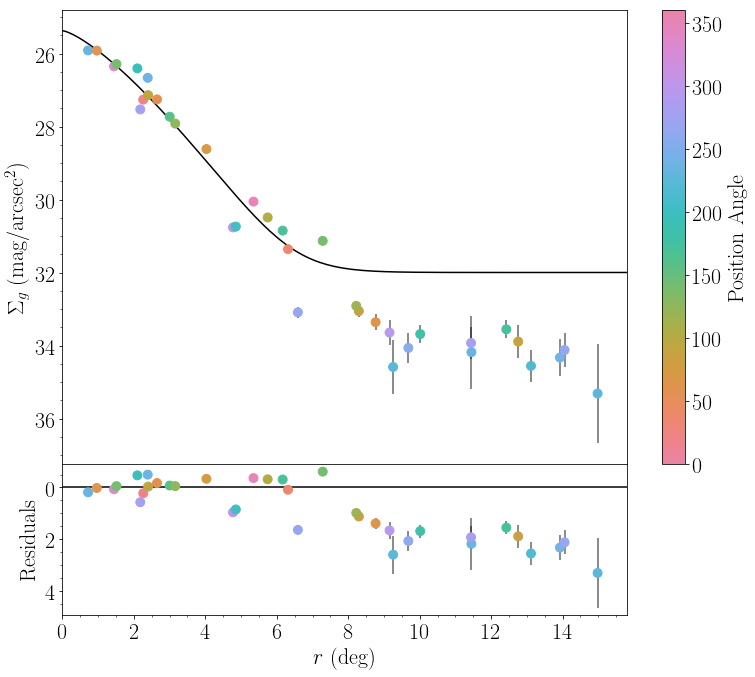

In [50]:
params = np.percentile(samples, 50, axis=0)
print params
SB_profile_fit(all_data[3], all_data[4], all_data[1], all_data[2], all_data[0], params)

In [123]:
params = np.percentile(samples, [16, 50, 84], axis=0)
print params.T[0][1],(params.T[0][2] - params.T[0][0])/2
print params.T[1][1],(params.T[1][2] - params.T[1][0])/2
print params.T[2][1],(params.T[2][2] - params.T[2][0])/2
print params.T[3][1],(params.T[3][2] - params.T[3][0])/2
print params.T[4][1],(params.T[4][2] - params.T[4][0])/2
print params.T[5][1],(params.T[5][2] - params.T[5][0])/2

1.158642854439218e-09 7.252965935103441e-11
0.7766489989829548 0.0398226968999148
1.0856471713381717 0.02505117249032396
1.9734942173490647e-12 5.827561539333533e-14
0.15796613298831513 0.00583167900818872
76.40588341434626 1.1453241536569152


# Fitting the star count profile

In [147]:
name_file_young = '/home/pol/Documents/PhD/CMD_SMASH/StarCounts_errors_young_15deg_12M.dat'
young_data = read_txt(name_file_young)

In [139]:
def lnlike(theta, x, pa, y, yerr):
    I_c, h, n, I_b, e, line_of_nodes = theta
    #pa_radians = np.deg2rad(pa)
    #r_prime = np.sqrt(x*x * (np.cos(pa - line_of_nodes)**2 + np.sin(pa - line_of_nodes)**2 / (1.0-e*e)))
    r_prime = elliptical_radius(x, pa, line_of_nodes, e)
    model = I_c * np.exp(-1.0 * (r_prime/h)**(1.0/n)) + I_b
    return -np.sum((y-model)**2 / (yerr)**2)

In [140]:
def lnprior(theta):
    I_c, h, n, I_b, e, line_of_nodes = theta
    if 1e5 < I_c < 5e7 and 0.1 < h < 6.0 and 0.0 < n < 10.0 and 1 < I_b < 5e3 and 0.0 < e < 0.4 and 0.0 <= line_of_nodes < 360:
        return 0.0
    return -np.inf

In [141]:
def lnprob(theta, x, pa, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, pa, y, yerr)

In [148]:
ndim, nwalkers = 6, 100
init_pos = [[1e5, 1.0, 0.5, 1e2, 0.1, 3.0] + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

In [149]:
#distance_SMC = 62 #kpc
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(young_data[1], young_data[2], young_data[3], young_data[4]))
number_iterations = 5000
sampler.run_mcmc(init_pos, number_iterations)

(array([[5.00188668e+06, 1.18231180e-01, 1.63930132e+00, 2.89373006e+01,
         1.73765339e-01, 5.07311958e+00],
        [5.69001436e+06, 1.07224513e-01, 1.67766193e+00, 2.88188547e+01,
         1.84359776e-01, 5.75134165e+00],
        [6.00916262e+06, 1.05843546e-01, 1.67516071e+00, 2.96696985e+01,
         1.83882375e-01, 6.27996811e+00],
        [5.58290210e+06, 1.11981324e-01, 1.65941196e+00, 2.86739895e+01,
         1.91863912e-01, 3.03604444e+00],
        [5.57108269e+06, 1.07628840e-01, 1.67504806e+00, 2.91096788e+01,
         1.84287518e-01, 4.69069625e+00],
        [5.74115749e+06, 1.05043953e-01, 1.68594017e+00, 2.60187659e+01,
         1.83185790e-01, 4.43795924e+00],
        [5.75883722e+06, 1.07405631e-01, 1.67723960e+00, 2.75925929e+01,
         1.86707064e-01, 5.68536502e+00],
        [5.80545274e+06, 1.04667685e-01, 1.68633086e+00, 2.93007844e+01,
         1.78915014e-01, 5.81291458e+00],
        [5.80724073e+06, 1.07654273e-01, 1.67295806e+00, 2.86396753e+01,
       

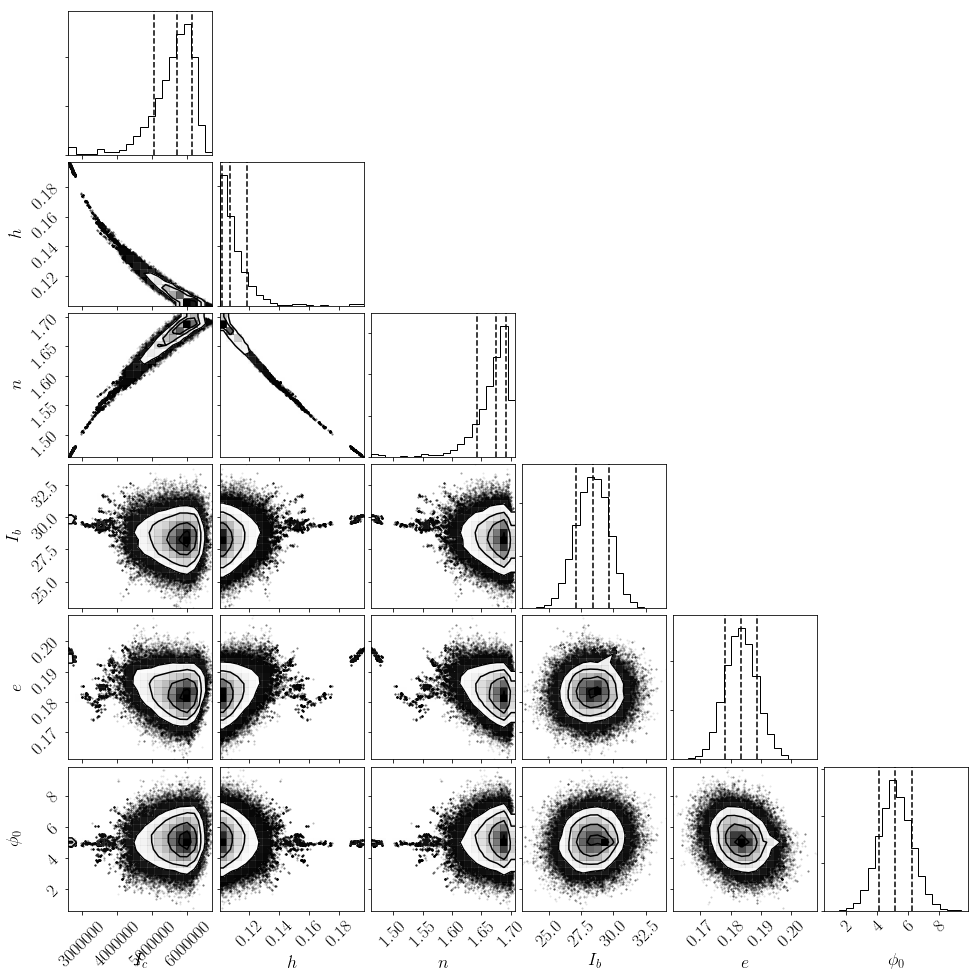

In [150]:
samples = sampler.chain[:, 2000:, :].reshape((-1, ndim))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':18})
fig = corner.corner(samples, labels=["$I_c$", "$h$", "$n$", "$I_b$", "$e$", "$\phi_0$"], quantiles = [0.16, 0.50, 0.84])
fig.savefig("/home/pol/Documents/PhD/CMD_SMASH/Plots/SC_sersic_corner_young.pdf")

In [17]:
def sersic_profile_counts(x, params):
    I_c, h, n, I_b, e, line_of_nodes = params
    #r = x + a * np.cos(np.deg2rad(pa) + line_of_nodes)
    return I_c * np.exp(-1.0 * (x/h)**(1.0/n)) + I_b

In [151]:
def SC_profile_fit(fields_data, fields_errors, fields_radius, fields_pa, fields_number, params):
    I_c, h, n, I_b, e, line_of_nodes = params

    x_values = np.arange(0, 16.5, 0.1)
    y_values = sersic_profile_counts(x_values, params)
    
    r_prime = elliptical_radius(fields_radius, fields_pa, line_of_nodes, e)
    
    residual_values = fields_data - sersic_profile_counts(r_prime, params)
    #print np.std(residual_values)
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.size':22})
    plt.rcParams.update({'errorbar.capsize': 0})

    # first draw a circle in the cylindrical JCh color space. 
    # the third channel is hue in degrees. First is lightness and the second chroma
    color_circle = np.ones((256,3))*60
    color_circle[:,1] = np.ones((256))*45
    color_circle[:,2] = np.arange(0,360,360.0/256.0)
    color_circle_rgb = cspace_convert(color_circle, "JCh","sRGB1")
    cm2 = colors.ListedColormap(color_circle_rgb)
    
    #fields_coord = fields_coord.T
    fig = plt.figure(figsize= (14,7))
    fig.add_axes((0.,0.3,0.7,0.9))
    plt.scatter(r_prime, fields_data, c = fields_pa, cmap=cm2, vmin = 0, vmax = 360, s = 80, zorder=10)
    plt.errorbar(r_prime, fields_data, yerr = fields_errors, fmt='none', zorder=1, c='k', alpha = 0.6)
    plt.plot(x_values, y_values, c = 'k')
    #for number in fields_number:
    #    plt.annotate(str(number), (fields_radius, fields_data))
    cb = plt.colorbar()
    cb.set_label('Position Angle')
    plt.xlim(xmin=0, xmax=15.8)
    #plt.ylim(ymin=23, ymax=32)
    plt.ylabel('N')
    plt.minorticks_on()
    plt.yscale('log')
    #plt.gca().invert_yaxis()
    plt.gca().axes.get_xaxis().set_ticks([])
    
    fig.add_axes((0.,0.,0.56,0.3)) 
    plt.scatter(r_prime, residual_values, c = fields_pa, cmap=cm2, vmin = 0, vmax = 360, s = 80, zorder=10)
    plt.errorbar(r_prime, residual_values, yerr = fields_errors, fmt='none', zorder=1, c='k', alpha = 0.6)
    plt.xlabel('$r$ (deg)')
    plt.ylabel('Residuals')
    plt.minorticks_on()
    plt.axhline(0, c = 'k')
    plt.xlim(xmin=0, xmax=15.8)
    #plt.yscale('log')
    #plt.gca().invert_yaxis()
    
    #plt.tight_layout()
    plt.savefig('/home/pol/Documents/PhD/CMD_SMASH/Plots/SC_profile_15deg_young_fit.pdf', bbox_inches = 'tight')
    plt.show()
    plt.close()

[5.71598643e+06 1.07189004e-01 1.67522869e+00 2.84046057e+01
 1.83349047e-01 5.12858193e+00]


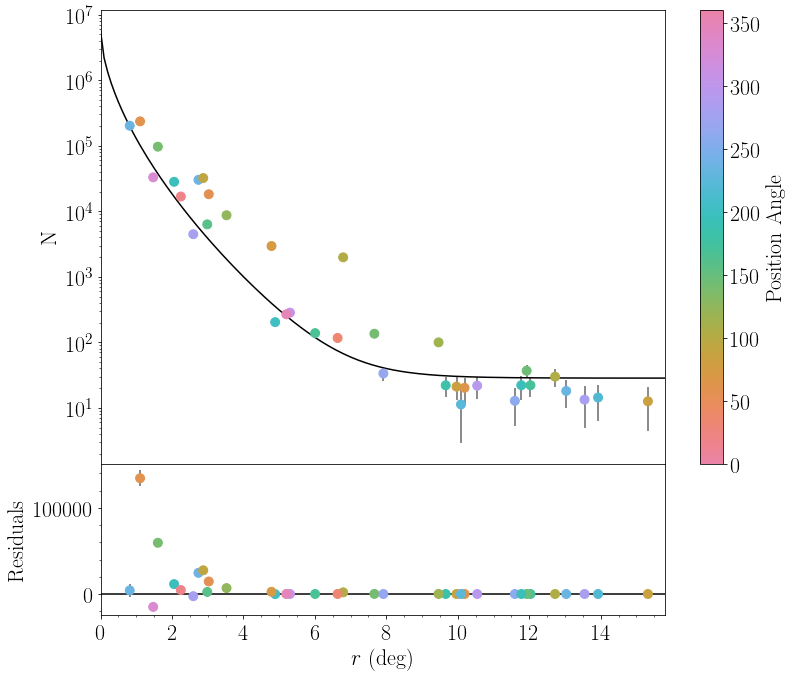

In [152]:
params = np.percentile(samples, 50, axis=0)
print params
SC_profile_fit(young_data[3], young_data[4], young_data[1], young_data[2], young_data[0], params)

In [153]:
params = np.percentile(samples, [16, 50, 84], axis=0)
print params.T[0][1],(params.T[0][2] - params.T[0][0])/2
print params.T[1][1],(params.T[1][2] - params.T[1][0])/2
print params.T[2][1],(params.T[2][2] - params.T[2][0])/2
print params.T[3][1],(params.T[3][2] - params.T[3][0])/2
print params.T[4][1],(params.T[4][2] - params.T[4][0])/2
print params.T[5][1],(params.T[5][2] - params.T[5][0])/2

5715986.42540873 532596.3187565254
0.10718900431894302 0.008079284480089377
1.6752286924334174 0.02531610173933252
28.404605727261156 1.2675744890205642
0.18334904730628784 0.005165793771378657
5.128581928796164 1.0468899857416156


# Change to elliptical coordinates

We try first with Nidever 2011 fit parameters.

In [36]:
def functions(parameters, r, theta):
    u, v = parameters
    hr = 1.0
    line_of_nodes = 154.4
    #name_file = '/home/pol/Documents/PhD/CMD_SMASH/SB_data_errors_mesa_decam_15deg_12M.dat'
    #all_data = read_txt(name_file)
    #fields_coords = np.stack((all_data[1],all_data[2]))
    #r = fields_coords[0]
    #theta = np.deg2rad(fields_coords[1] - line_of_nodes)
    #print r[0], np.rad2deg(theta[0])
    f = np.zeros(2)
    a = hr / np.sqrt(np.sinh(u)**2 + np.sin(v)**2)
    f[0] = r * np.cos(np.deg2rad(theta)) - a * np.cosh(u) * np.cos(v)
    f[1] = r * np.sin(np.deg2rad(theta)) - a * np.sinh(u) * np.sin(v)
    #for radius, angle in zip(r, theta):
    #    a = hr / np.sqrt(np.sinh(u)**2 + np.sin(v)**2)
    #    f[0] = radius * np.cos(angle) - a * np.cosh(u) * np.cos(v)
    #    f[1] = radius * np.sin(angle) - a * np.sinh(u) * np.sin(v)
    return f

In [39]:
name_file = '/home/pol/Documents/PhD/CMD_SMASH/SB_data_errors_mesa_decam_15deg_12M.dat'
all_data = read_txt(name_file)
fields_coords = np.stack((all_data[1],all_data[2]))
#r = fields_coords[0]
#theta = np.deg2rad(fields_coords[1] - line_of_nodes)
for r, theta in zip(fields_coords[0], fields_coords[1]):
    u, v = fsolve(functions, (1.0, 1.0), args=(r, theta))
    print u, np.rad2deg(v), r, theta-154.4

-12.132752801559146 53.809021614309756 4.543 152.261
-13.616022336968031 516.7956724172152 4.775 48.815
-5.0630383994264925 122.21851040971559 2.388 83.614
-12.674524530134551 81.31259161044753 2.122 124.30499999999998
-0.7699595161333256 32.84571285284019 1.367 175.82000000000002
-0.7094837350144934 112.81614051654238 0.718 81.023
-22.966055134408688 165.83449581034623 2.047 39.831999999999994
55.63561300846286 -179.49610830133568 9.646 26.02199999999999
0.36070825342422963 19.133031830982894 2.217 -135.447
1.6512171430080764 60.89852967116813 0.962 -95.328
1.1833325743269303 140.37717803938892 1.433 -14.857
-0.27910662090161803 195.2733506208758 2.851 4.3659999999999854
31.70316640563175 168.03013196101347 5.879 13.457999999999998
3.7378581816575696 56.59100811944655 2.648 -97.374
6.484630380944609 93.41663069273183 2.348 -60.68000000000001
12.58809275556465 125.06466409954909 3.008 -29.334000000000003
6.897359207502831 -188.016630730648 11.885 17.683999999999997
17.241287804510854 1

In [49]:
def polar_to_elliptical(r, theta, eccentricity, line_of_nodes):
    # Input parameters: 
    # r (arbitrary units)
    # theta (degrees)
    # eccentricity
    # line_of_nodes (in degrees)
    
    # First we transform to cartesian
    x = r * np.cos(np.deg2rad(theta - line_of_nodes))
    y = r * np.sin(np.deg2rad(theta - line_of_nodes))
    
    # Following: Che Sun. Explicit Equations to Transform from Cartesian to Elliptic Coordinates. Mathematical Modelling and Applications.
    # Vol. 2, No. 4, 2017, pp. 43-46. doi: 10.11648/j.mma.20170204.12 
    B = x*x + y*y - eccentricity*eccentricity
    p = (-B + np.sqrt(B*B + 4.0*eccentricity*eccentricity*y*y))/(2.0 * eccentricity * eccentricity)
    q = (-B - np.sqrt(B*B + 4.0*eccentricity*eccentricity*y*y))/(2.0 * eccentricity * eccentricity)
    
    eta0 = np.arcsin(np.sqrt(p))
    angle = cmath.phase(complex(x,y))
    if angle >= 0.0 and angle <= np.pi/2.0:
        v = eta0
    elif angle > np.pi/2.0 and angle <= np.pi:
        v = np.pi - eta0
    elif angle > -np.pi and angle <= -np.pi/2.0:
        v = np.pi + eta0
    elif angle > -np.pi/2.0 and angle < 0.0:
        v = 2.0*np.pi - eta0
    else:
        sys.exit('You fucked up.')
        
    v = np.rad2deg(v)
    
    #u = 0.5 * np.log(1.0 - 2.0*q + 2.0*np.sqrt(q*q - q))
    u = np.arcsinh(np.sqrt(-q))
    
    return np.array([u, v])

In [50]:
new_coords = []
for r, theta in zip(fields_coords[0], fields_coords[1]):
    new_coords.append(polar_to_elliptical(r, theta, 0.1, 154.4))
    print new_coords[-1], [r,theta-154.4]

[  4.50925122 152.25528066] [4.543, 152.261]
[ 4.55914082 48.82122637] [4.775, 48.815]
[ 3.86661576 83.61954589] [2.388, 83.614]
[  3.74829414 124.27539854] [2.122, 124.30499999999998]
[  3.30702463 175.80881088] [1.367, 175.82000000000002]
[ 2.6690315  81.10748081] [0.718, 81.023]
[ 3.71200103 39.86564036] [2.047, 39.831999999999994]
[ 5.26225907 26.0232139 ] [9.646, 26.02199999999999]
[  3.79187966 224.58213992] [2.217, -135.447]
[  2.95963612 264.70039455] [0.962, -95.328]
[  3.35444393 345.10831486] [1.433, -14.857]
[4.04309794 4.36867777] [2.851, 4.3659999999999854]
[ 4.76705445 13.45987644] [5.879, 13.457999999999998]
[  3.96988154 262.63119496] [2.648, -97.374]
[  3.84953231 299.29782962] [2.348, -60.68000000000001]
[  4.09686406 330.65247187] [3.008, -29.334000000000003]
[ 5.47099494 17.68458699] [11.885, 17.683999999999997]
[  4.71260465 309.25247088] [5.567, -50.74300000000001]
[  4.92662629 347.32871067] [6.896, -12.670000000000016]
[  5.16584652 267.99513055] [8.759, -92.00

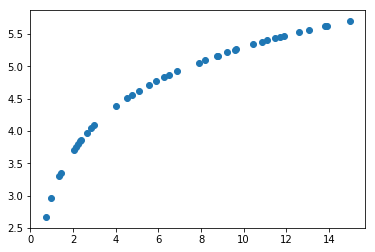

In [51]:
new_coords = np.array(new_coords)
plt.scatter(fields_coords[0], new_coords.T[0])
plt.show()

# Unimportant stuff follows

In [18]:
# Checking the BIC for the exponential and Sersic models.

BIC = np.log(len(all_data[0])) * 4 - 2 * lnlike_2(params[1], np.tan(np.deg2rad(all_data[1]))*distance_SMC, all_data[3], all_data[4])
print "BIC for 4:", BIC

BIC for 4: 1648149.7022299243


In [30]:
BIC = np.log(len(all_data[0])) * 3 - 2 * lnlike(params[1], np.tan(np.deg2rad(all_data[1]))*distance_SMC, all_data[3], all_data[4])
print "BIC for 3:", BIC

BIC for 3: 2048653.9095317929


In [35]:
print params[1][2]

6607.412090847957


In [36]:
# Good, now we choose the sersic model and subtract the background to all the points.
all_data[3] = all_data[3] - params[1][2]

In [41]:
print all_data[3]

[ 2.46376244e+04  2.37857737e+04  1.10514731e+06  6.83295354e+05
  1.44418088e+06  2.18601085e+06  1.34017840e+06  1.68264651e+03
  4.50618084e+05  2.31066952e+06  1.55439282e+06  4.41947214e+05
  2.54320597e+04  6.82492362e+05  7.38852954e+05  3.82722973e+05
  2.59663675e+03  3.37291803e+04  1.97358573e+04 -7.71971391e+02
  6.96884809e+02  8.65991479e+02 -2.12061176e+03 -1.29301561e+02
  4.94274272e+03  8.86105829e+02 -6.70690851e+02 -6.57894508e+01
 -1.79261813e+03 -1.32555737e+03 -1.24337888e+03 -1.51511504e+03
 -1.06677436e+03  3.54774983e+03 -1.29538849e+03  6.17979038e+04
  1.38544497e+04  1.88880753e+05 -7.93168401e+02]


In [64]:
#params = np.mean(samples.T[0]), np.mean(samples.T[1]), np.mean(samples.T[2])
StarCounts_profile_fit(all_data[3], all_data[4], fields_coords, params)

In [63]:
# Function that constructs the SB profile based on the retrieved magnitudes and the radial distance from the center of the SMC.
def StarCounts_profile_fit(fields_data, fields_errors, fields_coord, fit_params):

    distance_SMC = 62 #kpc
    
    #print fields_coord[1].shape, fields_data.shape
    
    A, r_e, b, n = fit_params[1]
    x = np.arange(start = 0.0, stop = 20, step = 0.1)
    b_matrix = np.zeros(len(x)) + b
    model = A * np.exp(- (x / r_e)**(1/n)) + b
    background_sigma = (fit_params.T[2][2] - fit_params.T[2][0])/2.0
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.size':24})
    fig = plt.figure(figsize= (12,9))
    ax = fig.add_subplot(111)

    # first draw a circle in the cylindrical JCh color space. 
    # the third channel is hue in degrees. First is lightness and the second chroma
    color_circle = np.ones((256,3))*60
    color_circle[:,1] = np.ones((256))*45
    color_circle[:,2] = np.arange(0,360,360.0/256.0)
    color_circle_rgb = cspace_convert(color_circle, "JCh","sRGB1")
    cm2 = colors.ListedColormap(color_circle_rgb)
    
    #fields_coord = fields_coord.T
    plot = ax.scatter(np.tan(np.deg2rad(fields_coord[0]))*distance_SMC, fields_data, c = fields_coord[1], cmap = cm2, s = 80, zorder=10, vmin = 0, vmax = 360)
    plt.errorbar(np.tan(np.deg2rad(fields_coord[0]))*distance_SMC, fields_data, yerr = fields_errors, fmt='none', zorder=1)
    #plt.plot(x, model, c = 'k', alpha = 0.8)
    #plt.plot(x, b_matrix, 'k--', alpha = 0.8)
    #plt.axhspan(fit_params[1][2] - background_sigma, fit_params[1][2] + background_sigma, alpha = 0.8, color = 'midnightblue', zorder = 10)
    #plt.axhspan(fit_params[1][2] - 2.0*background_sigma, fit_params[1][2] + 2.0*background_sigma, alpha = 0.4, color = 'midnightblue', zorder = 20)
    #for i, field_number in enumerate(fields_coord[0]):
    #    plt.annotate(field_number, (str(np.tan(np.deg2rad(fields_coord[1]))*distance_SMC), str(fields_data)))
    cb = plt.colorbar(plot)
    cb.set_label('Position Angle ($^\circ$)')
    plt.xlim(xmin=0, xmax = 17.5)
    plt.ylim(ymin=6e1)
    plt.yscale('log')
    plt.xlabel('r (kpc)')
    plt.ylabel('Star Counts (deg$^{-2}$)')
    plt.minorticks_on()
    #plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('/home/pol/Documents/PhD/CMD_SMASH/Plots/SC_profile_15deg_13D_old.pdf')
    plt.close()

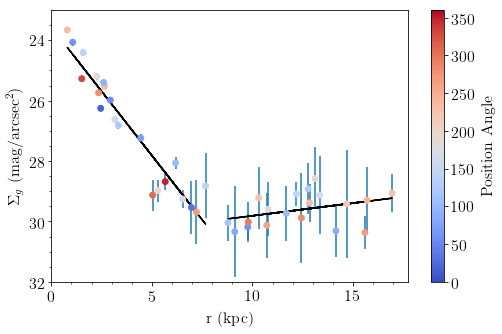

In [72]:
SB_profile_fit_mod(all_data[3], all_data[4], fields_coords)

In [62]:
distance_SMC = 63.4 #kpc
r_kpc = np.tan(np.deg2rad(fields_coords[0]))*distance_SMC
print r_kpc[r_kpc<7.7]

[5.03756693 5.29598923 2.64394563 2.34914939 1.51292555 0.79453641
 2.26604903 2.45442146 1.06459031 1.58600073 3.15734825 6.52826808
 2.93220257 2.59960839 3.3315299  6.17955959 7.66775208 7.21455048
 5.66387606 6.96470644 4.44670347]


# Testing with mock data

Preparing the mock data

In [23]:
def exp_model(A, r_e, b, n, r):
    model = A * np.exp(- (r/r_e)**(1/n) ) + b
    return model

In [26]:
A_true = 5e6 #star count at r=0
r_e_true = 2 #kpc
b_true = 4e3 #background
n_true = 0.7 #sersic index
sigma = 0.2 #percentage error
distance_SMC = 62 #kpc

In [27]:
mock_data = exp_model(A_true, r_e_true, b_true, n_true, np.tan(np.deg2rad(all_data[1]))*distance_SMC)
mock_errors = np.random.normal(scale = sigma*mock_data, size = all_data[1].shape)
mock_data = mock_data + mock_errors

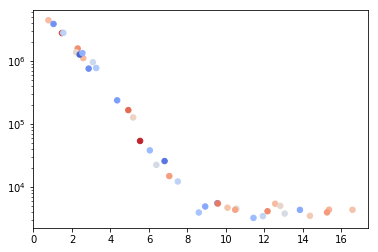

In [28]:
plt.scatter(np.tan(np.deg2rad(all_data[1]))*distance_SMC, mock_data, c = all_data[2], cmap=cm.coolwarm, vmin = 0, vmax = 360, s = 30)
plt.yscale('log')
plt.show()

In [29]:
ndim, nwalkers = 4, 100
init_pos = [[1e6, 1.5, 1e3, 1] + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [34]:
distance_SMC = 62 #kpc
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(np.tan(np.deg2rad(all_data[1]))*distance_SMC, mock_data, mock_errors))
number_iterations = 10000
sampler.run_mcmc(init_pos, number_iterations)

/home/pol/.local/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in power
  if __name__ == '__main__':


(array([[1.13712390e+06, 2.85316481e-01, 3.49595852e+03, 1.90340111e+00],
        [5.85199164e+06, 1.81772030e+00, 4.00730903e+03, 7.37350794e-01],
        [5.56273958e+06, 1.91862009e+00, 3.98279069e+03, 7.11358623e-01],
        [5.68058688e+06, 1.85899414e+00, 3.98148900e+03, 7.24249088e-01],
        [6.07966647e+06, 1.83059326e+00, 4.01281273e+03, 7.33429034e-01],
        [5.37582401e+06, 1.90287085e+00, 3.95309874e+03, 7.21948070e-01],
        [5.52435642e+06, 1.89857481e+00, 3.98071649e+03, 7.18210089e-01],
        [5.49913227e+06, 1.89448160e+00, 3.97879975e+03, 7.23481877e-01],
        [6.18855042e+06, 1.76078236e+00, 3.94432185e+03, 7.52053895e-01],
        [5.77151436e+06, 1.85490391e+00, 3.96373847e+03, 7.30567732e-01],
        [6.40449993e+06, 1.75185254e+00, 4.00024597e+03, 7.52236526e-01],
        [5.39664937e+06, 1.94472975e+00, 3.97584483e+03, 7.05396951e-01],
        [5.96283467e+06, 1.80713874e+00, 4.00420717e+03, 7.37935315e-01],
        [5.40999443e+06, 1.92039258e+0

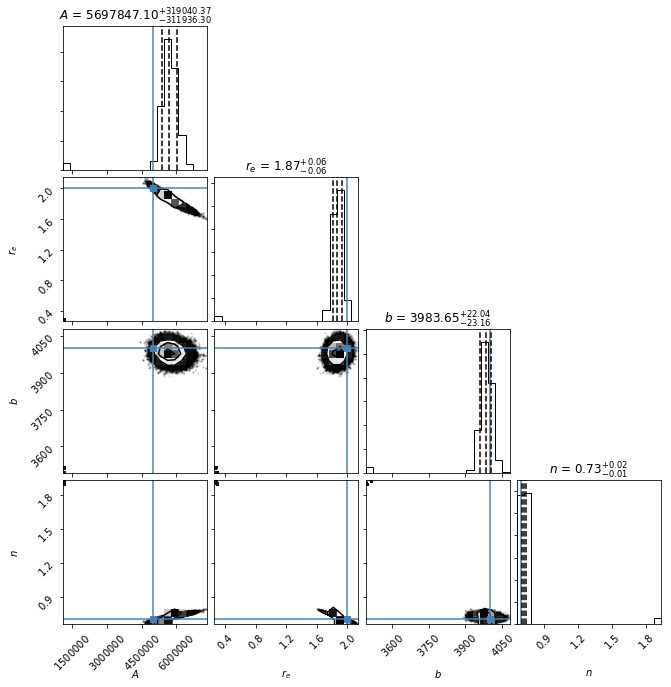

In [35]:
samples = sampler.chain[:, 4000:, :].reshape((-1, ndim))
fig = corner.corner(samples, labels=["$A$", "$r_e$", "$b$", "$n$"], quantiles = [0.16, 0.5, 0.84], show_titles=True, truths=[5e6,2.0,4e3,0.7], use_math_text=True)
fig.savefig("/home/pol/Documents/PhD/CMD_SMASH/Plots/test_emcee.png")

In [63]:
test_params = np.mean(samples.T[0]), np.mean(samples.T[1]), np.mean(samples.T[2])
StarCounts_profile_fit(mock_data, mock_errors, fields_coords, test_params)